<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/2020_11_24_GridSearchCV_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# !!DONE!! Ideally - no more changes here, there's a lot of meat to this one and I need to use it to generate results for report, can't afford to break it :) 

# WORDS OF CAUTION

I initially ran GridSearchCV on the whole X,y dataset (i.e. ignoring X_train/ y_train, X_test/ y_test) and spat out the best results without evaluation on unseen data. See...
* See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

i.e. With GridSearchCV, I need to..
* setup model
* fit with X_train/ y_train
* evaluate and find best model
* take best model and use X_test/ y_test on it





Also from...
* https://stackoverflow.com/a/55605798

"Internally, GridSearchCV splits the dataset given to it into various training and validation subsets, and, using the hyperparameter grid provided to it, finds the single set of hyperparameters that give the best score on the validation subsets.

The point of a train-test split is then, after this process is done, to perform one final scoring on the test data, which has so far been unknown to the model, to see if your hyperparameters have been overfit to the validation subsets. If it does well, then the next step is putting the model into production/deployment."

# Setup Colab env


In [1]:

import sklearn
sklearn.__version__
#!pip uninstall scikit-learn -y
#!pip install scikit-learn
!pip install --upgrade scikit-learn

     |████████████████████████████████| 6.8MB 8.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [1]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [2]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# peek at modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27  2020 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27  2020 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27  2020 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27  2020 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27  2020 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27  2020 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27  2020 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27  2020 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27  2020 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27  2020 9_soul-groove9_105_beat_4-4.mid
total 52
-rw------- 1 root root 29124 Nov 29 22:48 data_prep.py
-rw------- 1 root root  2904 Nov 18 21:57 pipeline_utils.py
drwx------ 2 root root  4096 May 10  2020 __pycache__
-rw------- 1 root root  7847 Aug 18 22:09 stats_n_features.py
-rw------- 1 root root 

## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [4]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [5]:
# regular imports
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

# object that provides colours for charts
from itertools import cycle

# sklearn imports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
from scipy import stats

In [7]:
# install required libs
!pip install mido

     |████████████████████████████████| 61kB 4.9MB/s 


In [8]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep as dp
import pipeline_utils as pu
import stats_n_features as sf

>> LOADING custom module, when: 2020-12-02 21:52:37.609716, module name: stats_n_features
>> LOADING custom module, when: 2020-12-02 21:52:37.610608, module name: data_prep
>> LOADING custom module, when: 2020-12-02 21:52:37.911228, module name: pipeline_utils


In [9]:
# test module function calls..
dp.test_function_call('bling')
sf.test_function_call('hello')

Test function in data_prep.py called and worked! when: 2020-12-02 21:52:37.940081,  param:bling
Test function in stats_n_features called and worked! when: 2020-12-02 21:52:37.940213,  param:hello


## Pandas display options

In [10]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Load & filter data...

In [11]:
##################################
######## LOAD

my_data = dp.load_all_data()
all_drummer_data = my_data.copy()
;

BULK LOAD: drummer1, drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
FILE name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
    loaded file: <midi file '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid' type 0, 1 tracks, 1300 messages>
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    track count: 1, tracks: [<midi track 'MIDI' 1300 messages>]
    MIDI file type: 0
    > processing track: <midi track 'MIDI' 1300 messages>
    __notes pre-filter: [36. 37. 38. 40. 43. 44. 51. 52. 53. 55.]
    __applying filter: [44]
    __notes post filter: [36. 37. 38. 40. 43. 51. 52. 53. 55.]
    note_on span - first tick: 3 , last tick: 30658 
    good instruments: 5, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 43.0: 'High Floor

''

## Single file tests..

In [12]:
##################################
######## EXPLORE SINGLE FILE

# experimenting on a single file here ...
key1 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid'
#key2 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'

test_data = all_drummer_data[key1]
df1 = test_data.tight_df.copy()
df1.head()

print('stats for: {}'.format(key1))
df1['beat_offset'].groupby(df1['note']).describe()
df1['velocity'].groupby(df1['note']).describe()


note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                  hh        55            7                1
           1                kick        64           10                1
           3                kick        57          -29                3
           3                  hh        31           -2                3
           5                  hh        54          -13                5

stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.0,27.0
kick,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.0,10.0
snare,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.5,55.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,50.436508,9.891003,30.0,44.0,49.0,56.00,83.0
kick,54.0,60.796296,15.543463,42.0,52.0,59.5,63.75,127.0
snare,79.0,71.506329,35.822523,8.0,33.0,90.0,102.00,117.0


In [13]:
# pull out notes in named bars...
display(df1.xs(1, level='bar_number')) 
display(df1.xs(2, level='bar_number')) 

,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,55,7,1
1,kick,64,10,1
3,kick,57,-29,3
3,hh,31,-2,3
5,hh,54,-13,5
5,snare,93,-5,5
7,hh,42,-16,7
8,snare,33,-12,8
10,snare,33,-14,10


,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,42,-7,1
1,kick,55,-5,1
3,kick,62,-10,3
3,hh,41,3,3
5,snare,94,4,5
5,hh,51,5,5
7,hh,45,7,7
8,snare,32,7,8
9,hh,43,2,9


## Filter songs...

Take a look at all file names in the complete data set...

In [14]:
list(all_drummer_data.keys())

['/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/6_hiphop-groove6_87_beat_4-4.m

Code to pull out data to test, based on selected songs. Also add 'y' (target/ observation) label.

In [15]:

# FILTER SONGS BEING TESTED, ADD LABEL

def addLabelCol(df, label):
  '''
  Input: data_prep.PerformanceData.tight_df
  Return: df with additional colum for Y/ label called 'drummer_ID'
  '''
  df.insert(0, 'drummer_ID', label) # add it as first col
  return df

def load_songs(style_filter=[]):

  songs_data = []

  if len(style_filter) == 0:
    print('>>>> Loading all songs ...')
    for next_file in all_drummer_data.keys():
      perf_data = all_drummer_data[next_file]
      file_name = perf_data.file_wrapper.my_file_name
      print('  __{}'.format(file_name))
      df1 = perf_data.tight_df.copy()
      df2 = addLabelCol(df1, perf_data.drummer_id)  
      df2.reset_index(drop=True, inplace=True)
      songs_data.append(df2)
    print('>>>> DONE loading all songs.')
  else:
    for next_style in style_filter:
      print('>>>> Loading songs in style: {} ...'.format(next_style))

      # iterate through loaded files, extract songs
      # matching the any styles set in 'next_filter'
      for next_file in all_drummer_data.keys():
        perf_data = all_drummer_data[next_file]
        file_name = perf_data.file_wrapper.my_file_name
        if next_style in file_name:
          print('  __{}'.format(file_name))
          df1 = perf_data.tight_df.copy()
          df2 = addLabelCol(df1, perf_data.drummer_id)  
          df2.reset_index(drop=True, inplace=True)
          songs_data.append(df2)
        else:
          #print('  ... ignoring: {}'.format(file_name))
          pass
    print('>>>> DONE loading songs: {}'.format(style_filter))

  return songs_data

# specify style being processed
# 1_funk-groove1
# 3_soul-groove3
# 4_soul-groove4
# 6_hiphop-groove6
# 8_rock-groove8

#style_filter = "1_funk-groove1"  
#style_filter = "3_soul-groove3" 
#style_filter = "4_soul-groove4"
#style_filter = "6_hiphop-groove6"
#style_filter = "8_rock-groove8"

# empty list loads all data
#filtered_songs = load_songs(style_filter=[])
filtered_songs = load_songs(style_filter=["3_soul-groove3"])

# load ALL songs ...
#working_songs = load_songs()

# merge all into single df, drop indexes, reset default index
working_data = pd.concat(filtered_songs)
working_data.reset_index(inplace=True, drop=True)

# .. at this point, df 'working_data' is a collection
# of data for the same song, across all drummers, with
# DrummerID label

working_data.head(5)


>>>> Loading songs in style: 3_soul-groove3 ...
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer7/eval_session/3_soul-groove3_86_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer8/eval_session/3_soul-groove3_86_beat_4-4.mid
>>>> DONE loading songs: ['3_soul-groove3']


,drummer_ID,note,velocity,beat_offset,bar_beat_number
0,drummer1,hh,32,0,1
1,drummer1,kick,60,0,1
2,drummer1,snare,15,1,1
3,drummer1,hh,18,0,2
4,drummer1,hh,60,3,3


# Setup pipelines

In [16]:
working_data.corr()

,velocity,beat_offset,bar_beat_number
velocity,1.000000,0.150622,-0.049958
beat_offset,0.150622,1.000000,0.045267
bar_beat_number,-0.049958,0.045267,1.000000


## X, y split

Break into X, y before continuing ...

In [17]:
# BREAK INTO X, y
y = working_data['drummer_ID'].to_numpy()
X = working_data.drop(['drummer_ID' ], axis=1) #.to_numpy()

In [18]:
X.head(10)

,note,velocity,beat_offset,bar_beat_number
0,hh,32,0,1
1,kick,60,0,1
2,snare,15,1,1
3,hh,18,0,2
4,hh,60,3,3
5,hh,24,3,4
6,kick,52,4,4
7,snare,102,9,5
8,hh,46,9,5
9,hh,28,-2,6


## Create transformers

In [19]:
beat_pos_cats = list(np.arange(1, 17))
beat_pos_cats

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [20]:


t_one_hot_beat_pos = OneHotEncoder(drop='first', categories=[beat_pos_cats])    # beat_pos

t_scaler_std = StandardScaler(with_mean=True, with_std=True) # defaults made explict, velocity & offset

t_one_hot = OneHotEncoder(drop='first')    # instrument
t_scaler_robust = RobustScaler(quantile_range=(25, 75))  # velocity & offset
t_scaler_mm_1 = MinMaxScaler(feature_range=(0, 1))       # velocity
t_scaler_mm_2 = MinMaxScaler(feature_range=(-0.5, 0.5))  # offset

# col indexes, 0-3: note, velocity, beat_offset, bar_beat_number

# robust scaling of vel & offset, one hot for instrument  
t_v0_robust = [('t_scaler_robust', t_scaler_robust, [1, 2]), ('t_one_hot', t_one_hot, [0])]
ct_v0 = ColumnTransformer(transformers=t_v0_robust, remainder='passthrough', sparse_threshold=0)
 

# this should be equivalent to previous pipeline for KNN
# MinMax scaling of vel & offset, one hot for instrument & beat_pos
t_v1_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1]), # velocity 
               ('t_scaler_mm_2', t_scaler_mm_2, [2]),  # offset
               ('t_one_hot', t_one_hot, [0]),  # instrument
               ('t_one_hot_beat_pos', t_one_hot_beat_pos, [3])]  # beat_pos 
ct_v1 = ColumnTransformer(transformers=t_v1_mm, remainder='passthrough', sparse_threshold=0)

# MinMax scaling of vel & offset, one hot for instrument
t_v2_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1]), # velocity 
               ('t_scaler_mm_2', t_scaler_mm_2, [2]),  # offset
               ('t_one_hot', t_one_hot, [0])]  # instrument
ct_v2 = ColumnTransformer(transformers=t_v2_mm, remainder='passthrough', sparse_threshold=0)


# MinMax scaling of vel & offset, one hot for note
t_v3_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1, 2]), ('t_one_hot', t_one_hot, [0])]
ct_v3 = ColumnTransformer(transformers=t_v3_mm, remainder='passthrough', sparse_threshold=0)

# Std scaling of vel & offset, one hot for note and beat_pos.
t_v4_std = [('t_scaler_std', t_scaler_std, [1, 2]), # vel & offset
           ('t_one_hot', t_one_hot, [0]), # instrument, beat_pos
           ('t_one_hot_beat_pos', t_one_hot_beat_pos, [3])]  # beat_pos 
ct_v4 = ColumnTransformer(transformers=t_v4_std, remainder='passthrough', sparse_threshold=0)


In [21]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context


In [22]:
ct_v0
ct_v1
ct_v2
ct_v3
ct_v4

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_robust',
                                 RobustScaler(quantile_range=(25, 75)),
                                 [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),
                                ('t_one_hot', OneHotEncoder(drop='first'), [0]),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 [3])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_std', StandardScaler(), [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'), [0]),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 [3])])

## Sanity checking ..


Try a transformer, peek at the outputs...

In [23]:
output1 = ct_v1.fit_transform(X)
output2 = ct_v2.fit_transform(X)
output3 = ct_v3.fit_transform(X)
output4 = ct_v4.fit_transform(X)

In [24]:
output1.shape
pd.DataFrame(output1).head()

(1677, 19)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.221311,0.004202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.450820,0.004202,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.081967,0.012605,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.106557,0.004202,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.450820,0.029412,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
output2.shape
tmp_df = pd.DataFrame(output2)
tmp_df.head()
tmp_df.corr()


(1677, 5)

,0,1,2,3,4
0,0.221311,0.004202,0.0,0.0,1.0
1,0.450820,0.004202,1.0,0.0,1.0
2,0.081967,0.012605,0.0,1.0,1.0
3,0.106557,0.004202,0.0,0.0,2.0
4,0.450820,0.029412,0.0,0.0,3.0


,0,1,2,3,4
0,1.000000,0.150622,-0.201766,0.125502,-0.049958
1,0.150622,1.000000,-0.003759,-0.037314,0.045267
2,-0.201766,-0.003759,1.000000,-0.241587,0.042524
3,0.125502,-0.037314,-0.241587,1.000000,-0.008819
4,-0.049958,0.045267,0.042524,-0.008819,1.000000


In [26]:
output3.shape
tmp_df = pd.DataFrame(output3)
tmp_df.head()
tmp_df.corr()

(1677, 5)

,0,1,2,3,4
0,0.221311,0.504202,0.0,0.0,1.0
1,0.450820,0.504202,1.0,0.0,1.0
2,0.081967,0.512605,0.0,1.0,1.0
3,0.106557,0.504202,0.0,0.0,2.0
4,0.450820,0.529412,0.0,0.0,3.0


,0,1,2,3,4
0,1.000000,0.150622,-0.201766,0.125502,-0.049958
1,0.150622,1.000000,-0.003759,-0.037314,0.045267
2,-0.201766,-0.003759,1.000000,-0.241587,0.042524
3,0.125502,-0.037314,-0.241587,1.000000,-0.008819
4,-0.049958,0.045267,0.042524,-0.008819,1.000000


In [27]:
output4.shape
tmp_df = pd.DataFrame(output4)
tmp_df.head()
tmp_df.corr()

(1677, 19)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.720137,0.698765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.149115,0.698765,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.247897,0.778851,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.154763,0.698765,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.149115,0.939025,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.000000,0.150622,-0.201766,0.125502,-0.130459,-0.068814,-0.122232,0.343909,-0.096487,-0.054483,0.011297,0.091035,-0.142940,0.020554,-0.088922,0.333274,-0.093295,-0.025495,-0.151026
1,0.150622,1.000000,-0.003759,-0.037314,0.031347,-0.035863,-0.062804,0.030702,0.070393,-0.042789,0.036657,0.015125,0.040827,-0.037264,-0.043999,0.004116,0.080055,-0.043771,0.012377
2,-0.201766,-0.003759,1.000000,-0.241587,-0.122355,-0.126273,0.181220,-0.155465,-0.108186,-0.112507,-0.071415,-0.109061,0.158222,0.181220,-0.109931,-0.154137,0.171982,-0.115034,0.100900
3,0.125502,-0.037314,-0.241587,1.000000,0.027119,0.056748,-0.115770,0.255062,-0.063459,-0.051719,0.166881,-0.081001,-0.053756,-0.121818,-0.065257,0.252834,-0.085083,-0.030837,-0.031101
4,-0.130459,0.031347,-0.122355,0.027119,1.000000,-0.052377,-0.064760,-0.064486,-0.044874,-0.046667,-0.065033,-0.045238,-0.068256,-0.064760,-0.045598,-0.063934,-0.066926,-0.047715,-0.064760
5,-0.068814,-0.035863,-0.126273,0.056748,-0.052377,1.000000,-0.066833,-0.066550,-0.046311,-0.048161,-0.067116,-0.046686,-0.070441,-0.066833,-0.047059,-0.065982,-0.069069,-0.049243,-0.066833
6,-0.122232,-0.062804,0.181220,-0.115770,-0.064760,-0.066833,1.000000,-0.082284,-0.057260,-0.059547,-0.082983,-0.057724,-0.087095,-0.082634,-0.058184,-0.081581,-0.085398,-0.060885,-0.082634
7,0.343909,0.030702,-0.155465,0.255062,-0.064486,-0.066550,-0.082284,1.000000,-0.057018,-0.059295,-0.082631,-0.057479,-0.086726,-0.082284,-0.057938,-0.081235,-0.085036,-0.060627,-0.082284
8,-0.096487,0.070393,-0.108186,-0.063459,-0.044874,-0.046311,-0.057260,-0.057018,1.000000,-0.041262,-0.057502,-0.039999,-0.060351,-0.057260,-0.040318,-0.056530,-0.059175,-0.042189,-0.057260
9,-0.054483,-0.042789,-0.112507,-0.051719,-0.046667,-0.048161,-0.059547,-0.059295,-0.041262,1.000000,-0.059799,-0.041596,-0.062762,-0.059547,-0.041928,-0.058788,-0.061539,-0.043874,-0.059547


## Train/ test split...

In [28]:
# TEST/ TRAIN SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)


In [29]:
X_train.head(3)

,note,velocity,beat_offset,bar_beat_number
1295,snare,113,12,13
179,hh,43,-6,5
559,hh,23,-12,6


In [30]:
X_train.describe()
X_test.describe()

,velocity,beat_offset,bar_beat_number
count,1341.000000,1341.000000,1341.000000
mean,55.164057,-8.850858,8.665175
std,32.255717,12.649175,4.692854
min,5.000000,-60.000000,1.000000
25%,31.000000,-16.000000,5.000000
50%,44.000000,-9.000000,9.000000
75%,75.000000,-1.000000,13.000000
max,127.000000,59.000000,16.000000


,velocity,beat_offset,bar_beat_number
count,336.000000,336.000000,336.000000
mean,55.327381,-8.223214,8.422619
std,32.130796,11.839254,4.720229
min,5.000000,-44.000000,1.000000
25%,32.000000,-16.000000,4.000000
50%,43.000000,-8.000000,8.500000
75%,73.000000,-1.000000,13.000000
max,127.000000,45.000000,16.000000


## Some pipelines

In [31]:
# setup our pre-processing and modelling pipeline
pipe_v0 = Pipeline(steps=[('prep',ct_v0), ('knn', KNeighborsClassifier(7))])
pipe_v1 = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
pipe_v2 = Pipeline(steps=[('prep',ct_v2), ('knn', KNeighborsClassifier(7))])
pipe_v3 = Pipeline(steps=[('prep',ct_v3), ('knn', KNeighborsClassifier(7))])
pipe_v4 = Pipeline(steps=[('prep',ct_v4), ('knn', KNeighborsClassifier(7))])


# Test pipelines

## Util functions


In [32]:

def KNN_predict(X_train, y_train, X_test, n=5):
  # Fit model, do predictions

  KNN_model = KNeighborsClassifier(n)
  display(KNN_model)
  KNN_model.fit(X_train, y_train)
  return KNN_model.predict(X_test)

def KNN_results(pred, test, labels):
  # evaluate results

  print('\nKNN Accuracy score...')
  print('  KNN: {}'.format(accuracy_score(pred, test)))

  print('\nKNN classification report...')
  print(classification_report(pred, test))

def c_matrix(pred, test, labels):
  # plot results

  print('\nConfusion matrix...')
  matrix2 = confusion_matrix(pred, test)
  m_df = pd.DataFrame(matrix2, index=labels, columns=labels)
  _ = plt.figure(figsize=(6, 6))
  sns.heatmap(m_df, annot=True, cbar=None, cmap="Reds")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()



## Manual fit model, do predictions

Testing single model by hand

In [33]:
print('fitting the pipeline ...')
pipe_v3.fit(X_train, y_train)

print('predicting ...')
predictions_1 = pipe_v3.predict(X_test)

fitting the pipeline ...


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

predicting ...


## Evaluate model results


KNN Accuracy score...
  KNN: 0.6994047619047619

KNN classification report...
              precision    recall  f1-score   support

    drummer1       0.76      0.66      0.70       108
    drummer5       0.70      0.64      0.67        91
    drummer7       0.52      0.78      0.62        59
    drummer8       0.86      0.77      0.81        78

    accuracy                           0.70       336
   macro avg       0.71      0.71      0.70       336
weighted avg       0.72      0.70      0.70       336


Confusion matrix...


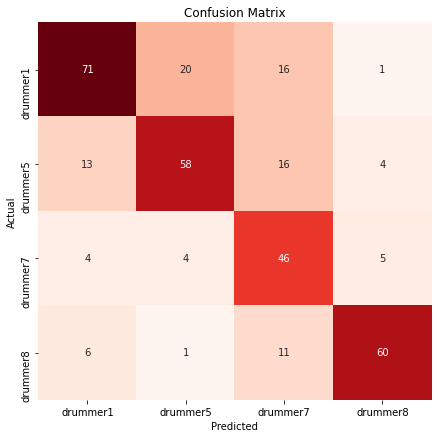

In [34]:
# y = list of all y values from dataset
classes = np.unique(y)
KNN_results(predictions_1, y_test, classes)
c_matrix(predictions_1, y_test, classes)

# K-fold CV, manual loop thru pipes

Compares..
* k=1-20
* 4 different pre-processing pipes

::TODO:: try different cv values.

In [35]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline

# list of ColumnTransformers setup earlier ..
cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]


results = []
best_score = 0
best_info = ''
best_pipe = None
best_k = 0

kf = KFold(n_splits=10, shuffle=True, random_state=27)

for idx, ct in enumerate(cts):
  print("\n_______________________________________________________")
  print("\n>>>> pipe #{}.. \n".format(idx))
  
  # Calculating error for K values between 1 and 20
  for next_k in range(1, 20):
    next_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier(next_k))])
    cv_results = cross_val_score(next_pipe, X_train, y_train, cv=kf, scoring="accuracy", n_jobs=-1 )
    results.append(cv_results)

    # print out put of this run.
    this_mean = cv_results.mean()
    this_run = "pipe #{}, k={}, mean:{}".format(idx, next_k, this_mean)
    print('\n\n ___ '+this_run)
    cv_results

    # check for best
    if this_mean > best_score:
      best_score = this_mean
      best_info = this_run
      best_pipe = next_pipe
      best_k = next_k
    
print("\n\nBest score was > {}".format(best_score))
print(best_info)




_______________________________________________________

>>>> pipe #0.. 



 ___ pipe #0, k=1, mean:0.6576782752902156


array([0.71111111, 0.67910448, 0.67910448, 0.64925373, 0.59701493,
       0.59701493, 0.67910448, 0.69402985, 0.59701493, 0.69402985])



 ___ pipe #0, k=2, mean:0.6278385848535103


array([0.6962963 , 0.6119403 , 0.61940299, 0.58208955, 0.6119403 ,
       0.63432836, 0.64179104, 0.6641791 , 0.55970149, 0.65671642])



 ___ pipe #0, k=3, mean:0.6404754007739082


array([0.76296296, 0.62686567, 0.64925373, 0.58208955, 0.62686567,
       0.64179104, 0.62686567, 0.64179104, 0.57462687, 0.67164179])



 ___ pipe #0, k=4, mean:0.632277501381979


array([0.74814815, 0.61940299, 0.64179104, 0.58208955, 0.61940299,
       0.64179104, 0.62686567, 0.55970149, 0.59701493, 0.68656716])



 ___ pipe #0, k=5, mean:0.6337976782752903


array([0.71111111, 0.64179104, 0.61940299, 0.63432836, 0.62686567,
       0.63432836, 0.64925373, 0.59701493, 0.55223881, 0.67164179])



 ___ pipe #0, k=6, mean:0.6338087341072416


array([0.6962963 , 0.64925373, 0.62686567, 0.59701493, 0.6641791 ,
       0.65671642, 0.6119403 , 0.59701493, 0.55223881, 0.68656716])



 ___ pipe #0, k=7, mean:0.6382808181315645


array([0.7037037 , 0.64179104, 0.6119403 , 0.60447761, 0.6641791 ,
       0.64179104, 0.63432836, 0.58955224, 0.56716418, 0.7238806 ])



 ___ pipe #0, k=8, mean:0.6233554449972359


array([0.7037037 , 0.62686567, 0.57462687, 0.59701493, 0.64925373,
       0.58955224, 0.61940299, 0.59701493, 0.58955224, 0.68656716])



 ___ pipe #0, k=9, mean:0.6091873963515755


array([0.68888889, 0.59701493, 0.52985075, 0.57462687, 0.63432836,
       0.61940299, 0.65671642, 0.56716418, 0.54477612, 0.67910448])



 ___ pipe #0, k=10, mean:0.597241569928137


array([0.6962963 , 0.58955224, 0.57462687, 0.57462687, 0.59701493,
       0.6119403 , 0.57462687, 0.53731343, 0.52985075, 0.68656716])



 ___ pipe #0, k=11, mean:0.6047153123272526


array([0.68148148, 0.6119403 , 0.58208955, 0.58208955, 0.6119403 ,
       0.60447761, 0.59701493, 0.54477612, 0.55970149, 0.67164179])



 ___ pipe #0, k=12, mean:0.5912935323383084


array([0.66666667, 0.56716418, 0.56716418, 0.52985075, 0.63432836,
       0.62686567, 0.58955224, 0.55223881, 0.52238806, 0.65671642])



 ___ pipe #0, k=13, mean:0.5733830845771144


array([0.66666667, 0.55970149, 0.52985075, 0.50746269, 0.58955224,
       0.57462687, 0.58955224, 0.54477612, 0.52985075, 0.64179104])



 ___ pipe #0, k=14, mean:0.5607131011608624


array([0.64444444, 0.53731343, 0.50746269, 0.52985075, 0.57462687,
       0.58955224, 0.55223881, 0.53731343, 0.52985075, 0.60447761])



 ___ pipe #0, k=15, mean:0.5637147595356551


array([0.62222222, 0.54477612, 0.53731343, 0.54477612, 0.55223881,
       0.60447761, 0.56716418, 0.52238806, 0.53731343, 0.60447761])



 ___ pipe #0, k=16, mean:0.5435655058043118


array([0.62222222, 0.51492537, 0.5       , 0.52985075, 0.56716418,
       0.58208955, 0.52238806, 0.53731343, 0.45522388, 0.60447761])



 ___ pipe #0, k=17, mean:0.5294029850746269


array([0.6       , 0.52985075, 0.5       , 0.5       , 0.52238806,
       0.57462687, 0.55223881, 0.47014925, 0.46268657, 0.58208955])



 ___ pipe #0, k=18, mean:0.5308789386401327


array([0.62222222, 0.51492537, 0.49253731, 0.48507463, 0.52238806,
       0.56716418, 0.54477612, 0.49253731, 0.47014925, 0.59701493])



 ___ pipe #0, k=19, mean:0.5196959646213378


array([0.60740741, 0.5       , 0.47014925, 0.47761194, 0.52238806,
       0.55223881, 0.53731343, 0.49253731, 0.47014925, 0.56716418])


_______________________________________________________

>>>> pipe #1.. 



 ___ pipe #1, k=1, mean:0.6875124378109453


array([0.73333333, 0.68656716, 0.67164179, 0.67164179, 0.64179104,
       0.6641791 , 0.7238806 , 0.70895522, 0.64179104, 0.73134328])



 ___ pipe #1, k=2, mean:0.6591763405196241


array([0.7037037 , 0.62686567, 0.64925373, 0.61940299, 0.67164179,
       0.67164179, 0.65671642, 0.71641791, 0.58208955, 0.69402985])



 ___ pipe #1, k=3, mean:0.6666500829187396


array([0.68888889, 0.64925373, 0.70149254, 0.62686567, 0.68656716,
       0.65671642, 0.65671642, 0.69402985, 0.59701493, 0.70895522])



 ___ pipe #1, k=4, mean:0.6778220011055833


array([0.71851852, 0.63432836, 0.7238806 , 0.65671642, 0.68656716,
       0.67164179, 0.64925373, 0.71641791, 0.6119403 , 0.70895522])



 ___ pipe #1, k=5, mean:0.6815644002211168


array([0.7037037 , 0.6641791 , 0.68656716, 0.67910448, 0.64179104,
       0.67164179, 0.70895522, 0.71641791, 0.62686567, 0.71641791])



 ___ pipe #1, k=6, mean:0.6875456053067994


array([0.68888889, 0.67910448, 0.68656716, 0.67910448, 0.70895522,
       0.64179104, 0.70149254, 0.73880597, 0.62686567, 0.7238806 ])



 ___ pipe #1, k=7, mean:0.6897788833609729


array([0.6962963 , 0.70149254, 0.6641791 , 0.69402985, 0.70895522,
       0.6641791 , 0.67910448, 0.68656716, 0.64179104, 0.76119403])



 ___ pipe #1, k=8, mean:0.6837866224433389


array([0.72592593, 0.65671642, 0.68656716, 0.68656716, 0.7238806 ,
       0.67164179, 0.64925373, 0.69402985, 0.6119403 , 0.73134328])



 ___ pipe #1, k=9, mean:0.6688888888888889


array([0.68888889, 0.64925373, 0.6641791 , 0.65671642, 0.65671642,
       0.64179104, 0.69402985, 0.67910448, 0.6119403 , 0.74626866])



 ___ pipe #1, k=10, mean:0.6576893311221669


array([0.6962963 , 0.65671642, 0.64179104, 0.64925373, 0.65671642,
       0.64925373, 0.6641791 , 0.65671642, 0.58955224, 0.71641791])



 ___ pipe #1, k=11, mean:0.6494914317302378


array([0.68148148, 0.6119403 , 0.63432836, 0.6641791 , 0.64925373,
       0.64925373, 0.67164179, 0.64179104, 0.57462687, 0.71641791])



 ___ pipe #1, k=12, mean:0.6300995024875622


array([0.66666667, 0.59701493, 0.60447761, 0.62686567, 0.65671642,
       0.63432836, 0.61940299, 0.62686567, 0.59701493, 0.67164179])



 ___ pipe #1, k=13, mean:0.6315920398009951


array([0.66666667, 0.59701493, 0.63432836, 0.62686567, 0.61940299,
       0.63432836, 0.65671642, 0.59701493, 0.59701493, 0.68656716])



 ___ pipe #1, k=14, mean:0.6308291873963516


array([0.68888889, 0.6119403 , 0.63432836, 0.60447761, 0.62686567,
       0.64925373, 0.62686567, 0.6119403 , 0.58208955, 0.67164179])



 ___ pipe #1, k=15, mean:0.6233609729132116


array([0.6962963 , 0.57462687, 0.61940299, 0.61940299, 0.59701493,
       0.64179104, 0.62686567, 0.59701493, 0.57462687, 0.68656716])



 ___ pipe #1, k=16, mean:0.6122056384742952


array([0.64444444, 0.58208955, 0.59701493, 0.62686567, 0.57462687,
       0.62686567, 0.62686567, 0.60447761, 0.55223881, 0.68656716])



 ___ pipe #1, k=17, mean:0.6039745715865118


array([0.67407407, 0.55970149, 0.61940299, 0.60447761, 0.54477612,
       0.60447761, 0.62686567, 0.60447761, 0.52238806, 0.67910448])



 ___ pipe #1, k=18, mean:0.5831011608623549


array([0.64444444, 0.52985075, 0.58208955, 0.59701493, 0.52985075,
       0.59701493, 0.57462687, 0.59701493, 0.49253731, 0.68656716])



 ___ pipe #1, k=19, mean:0.5674350469872858


array([0.63703704, 0.51492537, 0.53731343, 0.54477612, 0.52985075,
       0.59701493, 0.54477612, 0.55223881, 0.53731343, 0.67910448])


_______________________________________________________

>>>> pipe #2.. 



 ___ pipe #2, k=1, mean:0.6875124378109452


array([0.73333333, 0.68656716, 0.67164179, 0.67164179, 0.63432836,
       0.6641791 , 0.7238806 , 0.71641791, 0.63432836, 0.73880597])



 ___ pipe #2, k=2, mean:0.6591763405196241


array([0.7037037 , 0.62686567, 0.64925373, 0.61940299, 0.67164179,
       0.67164179, 0.65671642, 0.71641791, 0.58208955, 0.69402985])



 ___ pipe #2, k=3, mean:0.6666500829187396


array([0.68888889, 0.64925373, 0.70149254, 0.62686567, 0.68656716,
       0.65671642, 0.65671642, 0.69402985, 0.59701493, 0.70895522])



 ___ pipe #2, k=4, mean:0.6770757324488669


array([0.71851852, 0.63432836, 0.7238806 , 0.65671642, 0.68656716,
       0.67164179, 0.64925373, 0.70895522, 0.6119403 , 0.70895522])



 ___ pipe #2, k=5, mean:0.6808181315644003


array([0.7037037 , 0.6641791 , 0.68656716, 0.67910448, 0.64179104,
       0.67164179, 0.70895522, 0.70895522, 0.62686567, 0.71641791])



 ___ pipe #2, k=6, mean:0.6890381426202323


array([0.68888889, 0.68656716, 0.68656716, 0.67910448, 0.70895522,
       0.64925373, 0.70895522, 0.73134328, 0.62686567, 0.7238806 ])



 ___ pipe #2, k=7, mean:0.6890326147042565


array([0.6962963 , 0.70149254, 0.6641791 , 0.69402985, 0.70895522,
       0.6641791 , 0.67910448, 0.67910448, 0.64179104, 0.76119403])



 ___ pipe #2, k=8, mean:0.6852791597567717


array([0.72592593, 0.65671642, 0.68656716, 0.68656716, 0.7238806 ,
       0.67164179, 0.6641791 , 0.69402985, 0.6119403 , 0.73134328])



 ___ pipe #2, k=9, mean:0.6666500829187396


array([0.68888889, 0.64179104, 0.6641791 , 0.65671642, 0.65671642,
       0.64179104, 0.68656716, 0.67164179, 0.6119403 , 0.74626866])



 ___ pipe #2, k=10, mean:0.657689331122167


array([0.6962963 , 0.65671642, 0.64179104, 0.6641791 , 0.65671642,
       0.64925373, 0.65671642, 0.64925373, 0.58955224, 0.71641791])



 ___ pipe #2, k=11, mean:0.6479988944168049


array([0.68148148, 0.6119403 , 0.62686567, 0.67164179, 0.64925373,
       0.64925373, 0.6641791 , 0.63432836, 0.57462687, 0.71641791])



 ___ pipe #2, k=12, mean:0.6293532338308458


array([0.66666667, 0.60447761, 0.60447761, 0.62686567, 0.65671642,
       0.63432836, 0.6119403 , 0.61940299, 0.59701493, 0.67164179])



 ___ pipe #2, k=13, mean:0.6286069651741293


array([0.66666667, 0.59701493, 0.63432836, 0.61940299, 0.61940299,
       0.63432836, 0.64925373, 0.58208955, 0.59701493, 0.68656716])



 ___ pipe #2, k=14, mean:0.6300829187396352


array([0.68888889, 0.6119403 , 0.63432836, 0.59701493, 0.62686567,
       0.64925373, 0.62686567, 0.6119403 , 0.58208955, 0.67164179])



 ___ pipe #2, k=15, mean:0.6226147042564951


array([0.6962963 , 0.57462687, 0.61940299, 0.60447761, 0.59701493,
       0.64179104, 0.62686567, 0.60447761, 0.57462687, 0.68656716])



 ___ pipe #2, k=16, mean:0.6114593698175788


array([0.64444444, 0.58208955, 0.60447761, 0.6119403 , 0.57462687,
       0.62686567, 0.62686567, 0.60447761, 0.55223881, 0.68656716])



 ___ pipe #2, k=17, mean:0.6032283029297953


array([0.67407407, 0.55970149, 0.61940299, 0.59701493, 0.54477612,
       0.60447761, 0.62686567, 0.60447761, 0.52238806, 0.67910448])



 ___ pipe #2, k=18, mean:0.5823548922056385


array([0.64444444, 0.52985075, 0.58955224, 0.57462687, 0.53731343,
       0.59701493, 0.56716418, 0.60447761, 0.49253731, 0.68656716])



 ___ pipe #2, k=19, mean:0.5674350469872858


array([0.63703704, 0.51492537, 0.53731343, 0.55223881, 0.52985075,
       0.59701493, 0.54477612, 0.55223881, 0.53731343, 0.67164179])


_______________________________________________________

>>>> pipe #3.. 



 ___ pipe #3, k=1, mean:0.6875124378109452


array([0.73333333, 0.67910448, 0.67910448, 0.67164179, 0.63432836,
       0.6641791 , 0.7238806 , 0.71641791, 0.64179104, 0.73134328])



 ___ pipe #3, k=2, mean:0.6591763405196241


array([0.7037037 , 0.62686567, 0.64925373, 0.61940299, 0.67164179,
       0.67164179, 0.65671642, 0.71641791, 0.58208955, 0.69402985])



 ___ pipe #3, k=3, mean:0.6673963515754561


array([0.68888889, 0.64925373, 0.70149254, 0.61940299, 0.68656716,
       0.67164179, 0.65671642, 0.69402985, 0.59701493, 0.70895522])



 ___ pipe #3, k=4, mean:0.6763294637921504


array([0.71851852, 0.62686567, 0.7238806 , 0.65671642, 0.68656716,
       0.67164179, 0.64925373, 0.70895522, 0.6119403 , 0.70895522])



 ___ pipe #3, k=5, mean:0.6815644002211168


array([0.7037037 , 0.6641791 , 0.67910448, 0.68656716, 0.64179104,
       0.67164179, 0.70895522, 0.71641791, 0.62686567, 0.71641791])



 ___ pipe #3, k=6, mean:0.6890381426202323


array([0.68888889, 0.68656716, 0.68656716, 0.67910448, 0.70895522,
       0.64925373, 0.70895522, 0.73134328, 0.62686567, 0.7238806 ])



 ___ pipe #3, k=7, mean:0.6890326147042565


array([0.6962963 , 0.70149254, 0.6641791 , 0.69402985, 0.70895522,
       0.6641791 , 0.67910448, 0.67910448, 0.64179104, 0.76119403])



 ___ pipe #3, k=8, mean:0.6845328911000552


array([0.72592593, 0.65671642, 0.67910448, 0.68656716, 0.7238806 ,
       0.67164179, 0.6641791 , 0.69402985, 0.6119403 , 0.73134328])



 ___ pipe #3, k=9, mean:0.6666500829187396


array([0.68888889, 0.64179104, 0.6641791 , 0.65671642, 0.65671642,
       0.64179104, 0.68656716, 0.67164179, 0.6119403 , 0.74626866])



 ___ pipe #3, k=10, mean:0.6569430624654505


array([0.6962963 , 0.64925373, 0.64179104, 0.6641791 , 0.65671642,
       0.64925373, 0.65671642, 0.64925373, 0.58955224, 0.71641791])



 ___ pipe #3, k=11, mean:0.6479988944168049


array([0.68148148, 0.6119403 , 0.62686567, 0.67164179, 0.64925373,
       0.64925373, 0.6641791 , 0.63432836, 0.57462687, 0.71641791])



 ___ pipe #3, k=12, mean:0.6300995024875623


array([0.66666667, 0.60447761, 0.60447761, 0.62686567, 0.65671642,
       0.63432836, 0.6119403 , 0.61940299, 0.60447761, 0.67164179])



 ___ pipe #3, k=13, mean:0.6286069651741293


array([0.66666667, 0.59701493, 0.63432836, 0.61940299, 0.61940299,
       0.63432836, 0.64925373, 0.58208955, 0.59701493, 0.68656716])



 ___ pipe #3, k=14, mean:0.6300829187396352


array([0.68888889, 0.6119403 , 0.63432836, 0.59701493, 0.62686567,
       0.64925373, 0.62686567, 0.6119403 , 0.58208955, 0.67164179])



 ___ pipe #3, k=15, mean:0.6218684355997788


array([0.6962963 , 0.57462687, 0.61940299, 0.60447761, 0.59701493,
       0.64179104, 0.62686567, 0.59701493, 0.57462687, 0.68656716])



 ___ pipe #3, k=16, mean:0.6122056384742952


array([0.64444444, 0.58208955, 0.6119403 , 0.6119403 , 0.57462687,
       0.62686567, 0.62686567, 0.60447761, 0.55223881, 0.68656716])



 ___ pipe #3, k=17, mean:0.6032283029297953


array([0.67407407, 0.55970149, 0.61940299, 0.59701493, 0.54477612,
       0.60447761, 0.62686567, 0.60447761, 0.52238806, 0.67910448])



 ___ pipe #3, k=18, mean:0.5823548922056385


array([0.64444444, 0.52985075, 0.58955224, 0.57462687, 0.53731343,
       0.59701493, 0.56716418, 0.60447761, 0.49253731, 0.68656716])



 ___ pipe #3, k=19, mean:0.5674350469872858


array([0.63703704, 0.51492537, 0.53731343, 0.55223881, 0.52985075,
       0.59701493, 0.54477612, 0.55223881, 0.53731343, 0.67164179])


_______________________________________________________

>>>> pipe #4.. 



 ___ pipe #4, k=1, mean:0.6651409618573798


array([0.71111111, 0.6641791 , 0.68656716, 0.65671642, 0.6119403 ,
       0.62686567, 0.68656716, 0.67910448, 0.6119403 , 0.71641791])



 ___ pipe #4, k=2, mean:0.6405196241017137


array([0.7037037 , 0.62686567, 0.65671642, 0.58955224, 0.6119403 ,
       0.64179104, 0.67164179, 0.67164179, 0.56716418, 0.6641791 ])



 ___ pipe #4, k=3, mean:0.6509397457158651


array([0.74074074, 0.64179104, 0.6641791 , 0.62686567, 0.64925373,
       0.64925373, 0.65671642, 0.64179104, 0.57462687, 0.6641791 ])



 ___ pipe #4, k=4, mean:0.641984521835268


array([0.74074074, 0.6119403 , 0.6641791 , 0.6119403 , 0.62686567,
       0.64925373, 0.63432836, 0.59701493, 0.59701493, 0.68656716])



 ___ pipe #4, k=5, mean:0.6524599226091763


array([0.7037037 , 0.63432836, 0.64925373, 0.64925373, 0.65671642,
       0.64925373, 0.65671642, 0.63432836, 0.59701493, 0.69402985])



 ___ pipe #4, k=6, mean:0.6479988944168048


array([0.68148148, 0.64179104, 0.62686567, 0.60447761, 0.68656716,
       0.6641791 , 0.63432836, 0.63432836, 0.57462687, 0.73134328])



 ___ pipe #4, k=7, mean:0.6368159203980099


array([0.66666667, 0.63432836, 0.6119403 , 0.58208955, 0.6641791 ,
       0.62686567, 0.64179104, 0.62686567, 0.56716418, 0.74626866])



 ___ pipe #4, k=8, mean:0.6315809839690436


array([0.68148148, 0.64179104, 0.56716418, 0.58208955, 0.67910448,
       0.65671642, 0.61940299, 0.6119403 , 0.58955224, 0.68656716])



 ___ pipe #4, k=9, mean:0.6226147042564953


array([0.6962963 , 0.61940299, 0.51492537, 0.58955224, 0.65671642,
       0.62686567, 0.67164179, 0.60447761, 0.54477612, 0.70149254])



 ___ pipe #4, k=10, mean:0.6114483139856274


array([0.65925926, 0.61940299, 0.58208955, 0.55223881, 0.68656716,
       0.59701493, 0.58955224, 0.59701493, 0.54477612, 0.68656716])



 ___ pipe #4, k=11, mean:0.6107020453289109


array([0.65925926, 0.6119403 , 0.58208955, 0.55970149, 0.67910448,
       0.58955224, 0.6119403 , 0.56716418, 0.55970149, 0.68656716])



 ___ pipe #4, k=12, mean:0.589812050856827


array([0.65185185, 0.55970149, 0.53731343, 0.52985075, 0.67910448,
       0.58955224, 0.59701493, 0.56716418, 0.52238806, 0.6641791 ])



 ___ pipe #4, k=13, mean:0.5793642896627971


array([0.65185185, 0.55970149, 0.52238806, 0.52238806, 0.62686567,
       0.57462687, 0.59701493, 0.53731343, 0.54477612, 0.65671642])



 ___ pipe #4, k=14, mean:0.5749253731343283


array([0.6       , 0.57462687, 0.5       , 0.53731343, 0.64925373,
       0.59701493, 0.55970149, 0.52238806, 0.56716418, 0.64179104])



 ___ pipe #4, k=15, mean:0.5749253731343285


array([0.6       , 0.55223881, 0.5       , 0.53731343, 0.61940299,
       0.6119403 , 0.57462687, 0.53731343, 0.54477612, 0.67164179])



 ___ pipe #4, k=16, mean:0.5592592592592593


array([0.59259259, 0.52238806, 0.51492537, 0.53731343, 0.62686567,
       0.57462687, 0.58955224, 0.52238806, 0.48507463, 0.62686567])



 ___ pipe #4, k=17, mean:0.5510447761194031


array([0.6       , 0.54477612, 0.51492537, 0.52238806, 0.58208955,
       0.56716418, 0.58208955, 0.52985075, 0.46268657, 0.60447761])



 ___ pipe #4, k=18, mean:0.5555058043117744


array([0.62222222, 0.52985075, 0.55223881, 0.5       , 0.57462687,
       0.56716418, 0.59701493, 0.52238806, 0.5       , 0.58955224])



 ___ pipe #4, k=19, mean:0.5495577667219458


array([0.59259259, 0.51492537, 0.52238806, 0.52238806, 0.57462687,
       0.56716418, 0.58208955, 0.53731343, 0.49253731, 0.58955224])



Best score was > 0.6897788833609729
pipe #1, k=7, mean:0.6897788833609729


In [36]:
print('Best classifier k: {}, score: {}'.format(best_k, best_score))
print(best_info)
print('Best classifier pipe..')
best_pipe

Best classifier k: 7, score: 0.6897788833609729
pipe #1, k=7, mean:0.6897788833609729
Best classifier pipe..


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

In [37]:
#test_pipe = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
#test_pipe
_ = best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    drummer1       0.65      0.76      0.70        94
    drummer5       0.64      0.70      0.67        83
    drummer7       0.78      0.52      0.62        89
    drummer8       0.77      0.86      0.81        70

    accuracy                           0.70       336
   macro avg       0.71      0.71      0.70       336
weighted avg       0.71      0.70      0.69       336



# Stats on data being analysed

Quick review of stats of the data we're about to use in the model search...

In [39]:
X.describe()
pd.DataFrame(y).describe()
print('Drummers: {}'.format(np.unique(y)))
print('Beat positions: {}'.format(np.unique(X.bar_beat_number)))

,velocity,beat_offset,bar_beat_number
count,1677.000000,1677.000000,1677.000000
mean,55.196780,-8.725104,8.616577
std,32.221221,12.490194,4.697944
min,5.000000,-60.000000,1.000000
25%,31.000000,-16.000000,4.000000
50%,44.000000,-9.000000,9.000000
75%,75.000000,-1.000000,13.000000
max,127.000000,59.000000,16.000000


,0
count,1677
unique,4
top,drummer1
freq,447


Drummers: ['drummer1' 'drummer5' 'drummer7' 'drummer8']
Beat positions: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


... and some more useful numbers to review ...

In [40]:
print('DataFrame shape: {}\n'.format(working_data.shape))
print('Total notes per drummer...')
working_data.groupby(['drummer_ID'])['drummer_ID'].count() #describe() #['count']

print('\n\nTotal notes per drummer, per instrument...')
working_data.groupby(['drummer_ID', 'note'])['note'].count() #describe() #['count']
#working_data.groupby(['drummer_ID', 'note'])['note'].describe() #['count']

DataFrame shape: (1677, 5)

Total notes per drummer...


drummer_ID
drummer1    447
drummer5    419
drummer7    411
drummer8    400
Name: drummer_ID, dtype: int64



Total notes per drummer, per instrument...


drummer_ID  note 
drummer1    hh       252
            kick      80
            snare    115
drummer5    hh       255
            kick     111
            snare     53
drummer7    hh       256
            kick      95
            snare     60
drummer8    hh       255
            kick      96
            snare     49
Name: note, dtype: int64

In [41]:
working_data.groupby(['drummer_ID', 'note'])[['velocity', 'beat_offset']].describe() #['count']


velocity                                                     \
                    count        mean        std   min    25%    50%     75%   
drummer_ID note                                                                
drummer1   hh       252.0   35.952381   9.225685  12.0   30.0   36.0   41.00   
           kick      80.0   54.562500   7.287659  25.0   52.0   57.0   58.25   
           snare    115.0   44.452174  32.639241   5.0   25.0   30.0   81.00   
drummer5   hh       255.0   41.039216  18.766448  10.0   26.0   36.0   59.00   
           kick     111.0   28.675676   6.965058  13.0   21.5   31.0   34.00   
           snare     53.0   58.716981  40.465264   5.0    9.0   85.0   93.00   
drummer7   hh       256.0   57.949219  35.628934   7.0   33.0   43.5   71.00   
           kick      95.0   35.400000  10.311530  11.0   25.0   39.0   44.00   
           snare     60.0   67.133333  32.167183   5.0   62.0   79.5   89.00   
drummer8   hh       255.0   93.662745  25.050736  40.0   74.0   93.0  119.50   
           kick      96.0   58.364583  13.657556  38.0   44.0   57.5   72.25   
           snare     49.0  113.367347  16.430021  16.0  110.0  114.0  122.00   

                        beat_offset                                          \
                    max       count       mean        std   min   25%   50%   
drummer_ID note                                                               
drummer1   hh      68.0       252.0 -12.753968   9.298234 -41.0 -19.0 -13.0   
           kick    75.0        80.0 -14.125000  12.583267 -44.0 -24.0 -14.0   
           snare  121.0       115.0 -13.104348  14.659512 -48.0 -21.0 -13.0   
drummer5   hh      88.0       255.0 -13.815686   8.331786 -37.0 -19.0 -14.0   
           kick    40.0       111.0  -9.333333  11.171663 -42.0 -16.5  -8.0   
           snare  124.0        53.0 -11.358491  23.034334 -60.0 -26.0  -8.0   
drummer7   hh     127.0       256.0  -3.324219  10.848347 -32.0 -11.0  -2.5   
           kick    52.0        95.0  -6.894737  14.802583 -44.0 -17.0  -6.0   
           snare  107.0        60.0  -5.150000  18.218844 -51.0 -12.0  -4.0   
drummer8   hh     127.0       255.0  -3.807843   9.536004 -26.0 -11.0  -4.0   
           kick    85.0        96.0  -5.677083  12.126087 -29.0 -14.0  -5.0   
           snare  127.0        49.0  -5.897959  10.104135 -31.0 -12.0  -8.0   

                             
                  75%   max  
drummer_ID note              
drummer1   hh    -7.0  13.0  
           kick  -6.0  15.0  
           snare -6.0  58.0  
drummer5   hh    -9.0  15.0  
           kick  -2.0  14.0  
           snare -2.0  55.0  
drummer7   hh     4.0  24.0  
           kick   2.5  45.0  
           snare  3.0  59.0  
drummer8   hh     2.5  25.0  
           kick   1.0  39.0  
           snare -1.0  20.0

# GridSearch, kNN

Good links!
* https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-3-cross-validation-and-hyperparameter-tuning/ 
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://scikit-learn.org/stable/modules/compose.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

In [45]:
import sklearn
from  sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
sklearn.__version__  # should be 0.23.2


'0.23.2'

In [46]:
# note: 'grid_cts' is list of ColumnTransformers from earlier.
# list of ColumnTransformers setup earlier ..
# grid_cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
grid_cts = [ct_v0]


param_grid_v0 = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
     knn__p=[1, 2, 5], # knn distance functions to test
     prep=grid_cts # list of ColTransformers to search
)

# search all pipes in grid_cts
my_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier())])
grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v0, cv=10, verbose=1)

# search single pipe
# my_pipe = Pipeline(steps=[('prep',ct_v4), ('knn', KNeighborsClassifier())])
# grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v1, cv=10, verbose=1)

print('\n>>>>FITTING ....\n')
grid_search.fit(X_train,y_train)

# capture results in df
results_df = pd.DataFrame.from_dict(grid_search.cv_results_)
# display(results_df)

print('\n___BEST ESTIMATOR\n')
display(grid_search.best_estimator_)

print('\n___BEST SCORE\n')
display(grid_search.best_score_)

print('\n___BEST PARAMS\n')
display(grid_search.best_params_)





>>>>FITTING ....

Fitting 10 folds for each of 57 candidates, totalling 570 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:   12.2s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('t_scaler_std',
                                                                         StandardScaler(),
                                                                         [1,
                                                                          2]),
                                                                        ('t_one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         [0]),
                                                                        ('t_one_hot_beat_pos',
                                                                         OneHotEncoder(categories=[[1,
                                                                                                    2,
                                                                                                    3,
                                                                                                    4,
                                                                                                    5,
                                                                                                    6,
                                                                                                    7,
                                                                                                    8,
                                                                                                    9,
                                                                                                    10,
                                                                                                    11,
                                                                                                    12,
                                                                                                    13,
                                                                                                    14,
                                                                                                    15,
                                                                                                    16]],
                                                                                       drop='first'),
                                                                         [3])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'knn__p': [1, 2, 5],
                         'prep': [ColumnTransformer(remainder='passthrough',
                                                    sparse_threshold=0,
                                                    transformers=[('t_scaler_robust',
                                                                   RobustScaler(quantile_range=(25,
                                                                                                75)),
                                                                   [1, 2]),
                                                                  ('t_one_hot',
                                                                   OneHotEncoder(drop='first'),
                                                                   [0])])]},
             verbose=1)


___BEST ESTIMATOR



Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=3, p=1))])


___BEST SCORE



0.6592537313432836


___BEST PARAMS



{'knn__n_neighbors': 3,
 'knn__p': 1,
 'prep': ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                   transformers=[('t_scaler_robust',
                                  RobustScaler(quantile_range=(25, 75)),
                                  [1, 2]),
                                 ('t_one_hot', OneHotEncoder(drop='first'),
                                  [0])])}

## Now run best model with the test data ...

From the doc...
* GridSearchCV.predict(X) - Call predict on the estimator with the best found parameters.

In [47]:
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    drummer1       0.61      0.77      0.68        94
    drummer5       0.58      0.61      0.60        83
    drummer7       0.64      0.44      0.52        89
    drummer8       0.77      0.76      0.76        70

    accuracy                           0.64       336
   macro avg       0.65      0.64      0.64       336
weighted avg       0.64      0.64      0.63       336



# GridSearch, kNN, manual loop

In [92]:
# note: 'col_trans' is list of ColumnTransformers from earlier.
col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
#col_trans = [ct_v4]


param_grid_v1 = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
     knn__p=[1, 2, 5] # knn distance functions to test
)


overall_best_score = 0
overall_best_classifier = None


for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  my_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier())])
  grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v1, cv=10, verbose=1)

  print('\n>>>>FITTING ....\n')
  _ = grid_search.fit(X_train,y_train)

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(grid_search.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(grid_search.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(grid_search.best_params_)

  if grid_search.best_score_ > overall_best_score:
    overall_best_score = grid_search.best_score_
    overall_best_classifier = grid_search





_______________________________________________________

>>>> PIPE #0.. 


>>>>FITTING ....

Fitting 10 folds for each of 57 candidates, totalling 570 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



___BEST ESTIMATOR, pipe#0



[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:   11.8s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=3, p=1))])


___BEST SCORE, pipe#0



0.6592537313432836


___BEST PARAMS, pipe#0



{'knn__n_neighbors': 3, 'knn__p': 1}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #1.. 


>>>>FITTING ....

Fitting 10 folds for each of 57 candidates, totalling 570 fits

___BEST ESTIMATOR, pipe#1



[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:   21.2s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('knn', KNeighborsClassifier(n_neighbors=3, p=5))])


___BEST SCORE, pipe#1



0.6861083471531233


___BEST PARAMS, pipe#1



{'knn__n_neighbors': 3, 'knn__p': 5}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #2.. 


>>>>FITTING ....

Fitting 10 folds for each of 57 candidates, totalling 570 fits

___BEST ESTIMATOR, pipe#2



[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:   14.1s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=3, p=5))])


___BEST SCORE, pipe#2



0.6868546158098396


___BEST PARAMS, pipe#2



{'knn__n_neighbors': 3, 'knn__p': 5}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #3.. 


>>>>FITTING ....

Fitting 10 folds for each of 57 candidates, totalling 570 fits

___BEST ESTIMATOR, pipe#3



[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:   11.1s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=3, p=5))])


___BEST SCORE, pipe#3



0.6861083471531233


___BEST PARAMS, pipe#3



{'knn__n_neighbors': 3, 'knn__p': 5}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #4.. 


>>>>FITTING ....

Fitting 10 folds for each of 57 candidates, totalling 570 fits

___BEST ESTIMATOR, pipe#4



[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:   17.5s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_std',
                                                  StandardScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('knn', KNeighborsClassifier(n_neighbors=1))])


___BEST SCORE, pipe#4



0.6614483139856274


___BEST PARAMS, pipe#4



{'knn__n_neighbors': 1, 'knn__p': 2}

## Quick sanity check ...

In [98]:

print('overall best_score: {}, classifier score:{}'.format(overall_best_score, overall_best_classifier.best_score_))
print('overall best classifier...')
overall_best_classifier
overall_best_classifier.best_params_
pd.DataFrame.from_dict(overall_best_classifier.cv_results_).head()

overall best_score: 0.6868546158098396, classifier score:0.6868546158098396
overall best classifier...


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('t_scaler_mm_1',
                                                                         MinMaxScaler(),
                                                                         [1]),
                                                                        ('t_scaler_mm_2',
                                                                         MinMaxScaler(feature_range=(-0.5,
                                                                                                     0.5)),
                                                                         [2]),
                                                                        ('t_one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         [0])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'knn__p': [1, 2, 5]},
             verbose=1)

{'knn__n_neighbors': 3, 'knn__p': 5}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013313,0.003018,0.010604,0.001472,1,1,"{'knn__n_neighbors': 1, 'knn__p': 1}",0.688889,0.686567,0.619403,0.716418,0.626866,0.694030,0.679104,0.716418,0.723881,0.701493,0.685307,0.034020,4
1,0.012250,0.000928,0.010158,0.001295,1,2,"{'knn__n_neighbors': 1, 'knn__p': 2}",0.651852,0.686567,0.626866,0.723881,0.634328,0.723881,0.679104,0.708955,0.738806,0.686567,0.686081,0.036833,2
2,0.012373,0.000860,0.012704,0.000300,1,5,"{'knn__n_neighbors': 1, 'knn__p': 5}",0.644444,0.656716,0.634328,0.731343,0.626866,0.716418,0.679104,0.701493,0.746269,0.686567,0.682355,0.039395,5
3,0.011819,0.000280,0.009890,0.000165,2,1,"{'knn__n_neighbors': 2, 'knn__p': 1}",0.585185,0.619403,0.611940,0.686567,0.656716,0.634328,0.694030,0.708955,0.723881,0.656716,0.657772,0.043043,27
4,0.011826,0.000208,0.009911,0.000161,2,2,"{'knn__n_neighbors': 2, 'knn__p': 2}",0.577778,0.641791,0.619403,0.686567,0.641791,0.656716,0.679104,0.701493,0.716418,0.664179,0.658524,0.038799,26


## Chart results 

In [95]:
grid_results = pd.DataFrame(overall_best_classifier.cv_results_['params'])
grid_results['test_score'] = overall_best_classifier.cv_results_['mean_test_score']
grid_results['metric'] = grid_results['knn__p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
grid_results.head()

,knn__n_neighbors,knn__p,test_score,metric
0,1,1,0.685307,Manhattan
1,1,2,0.686081,Euclidean
2,1,5,0.682355,Minkowski
3,2,1,0.657772,Manhattan
4,2,2,0.658524,Euclidean


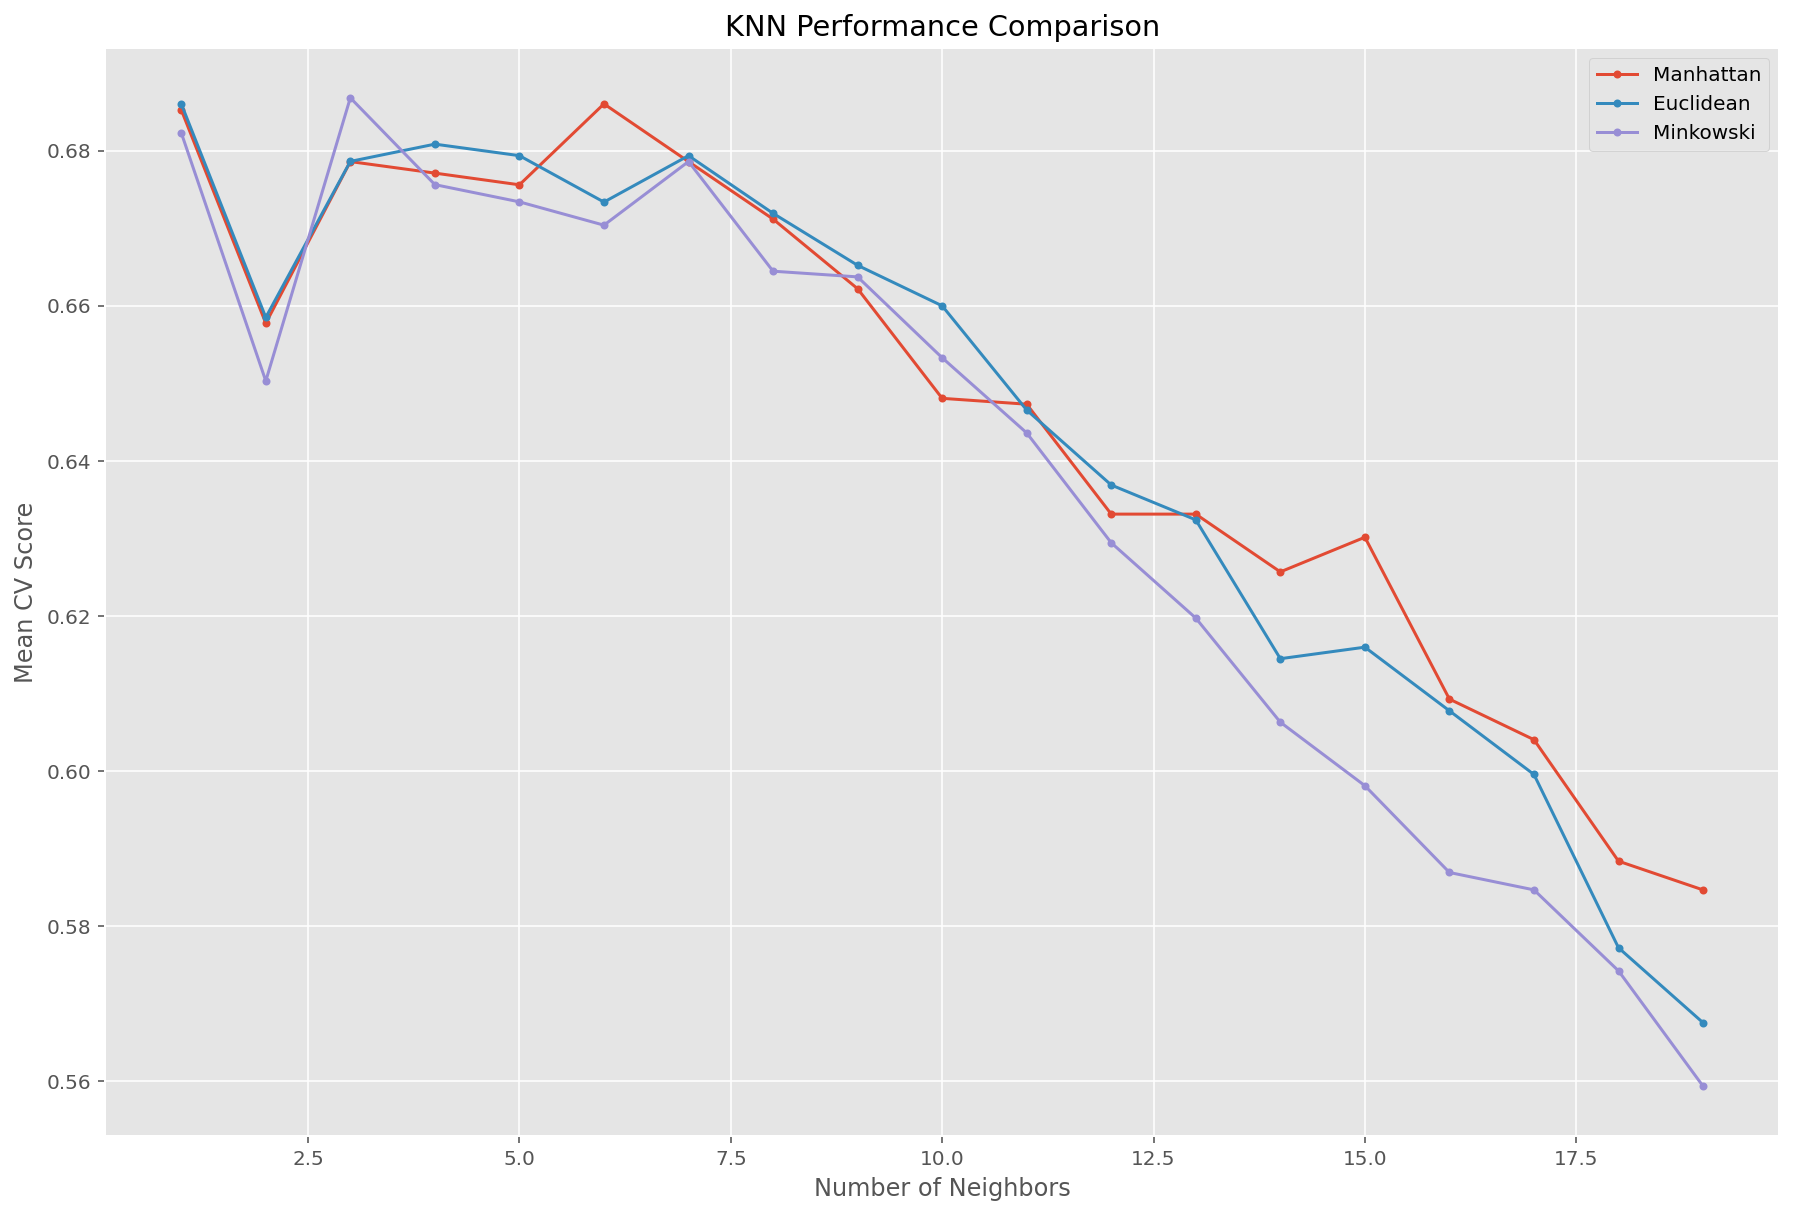

In [96]:

import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,10)

for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = grid_results[grid_results['metric'] == i]
    _ = plt.plot(temp['knn__n_neighbors'], temp['test_score'], marker = '.', label = i)
    
_ = plt.legend()
_ = plt.xlabel('Number of Neighbors')
_ = plt.ylabel("Mean CV Score")
_ = plt.title("KNN Performance Comparison")
plt.show()

## Run on test data

In [52]:
y_pred = overall_best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    drummer1       0.68      0.71      0.70        94
    drummer5       0.59      0.58      0.59        83
    drummer7       0.59      0.54      0.56        89
    drummer8       0.75      0.80      0.77        70

    accuracy                           0.65       336
   macro avg       0.65      0.66      0.65       336
weighted avg       0.65      0.65      0.65       336



# Decision Tree

- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
- https://scikit-learn.org/stable/modules/tree.html

In [66]:
X_train.describe()
X_train_prepped = ct_v4.fit_transform(X_train)

tmp_df1 = pd.DataFrame(X_train_prepped)
tmp_df1.head()


,velocity,beat_offset,bar_beat_number
count,1341.000000,1341.000000,1341.000000
mean,55.164057,-8.850858,8.665175
std,32.255717,12.649175,4.692854
min,5.000000,-60.000000,1.000000
25%,31.000000,-16.000000,5.000000
50%,44.000000,-9.000000,9.000000
75%,75.000000,-1.000000,13.000000
max,127.000000,59.000000,16.000000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.793714,1.649012,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.377254,0.225463,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.997530,-0.249053,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.873475,1.016323,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.245641,-1.198086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


DecisionTreeClassifier(max_depth=4)

[Text(418.5, 489.24, 'X[0] <= 0.134\ngini = 0.75\nsamples = 1341\nvalue = [353, 336, 322, 330]'),
 Text(209.25, 380.52000000000004, 'X[0] <= -0.548\ngini = 0.703\nsamples = 878\nvalue = [320, 262, 231, 65]'),
 Text(104.625, 271.8, 'X[2] <= 0.5\ngini = 0.648\nsamples = 506\nvalue = [178, 213, 114, 1]'),
 Text(52.3125, 163.08000000000004, 'X[0] <= -1.013\ngini = 0.635\nsamples = 391\nvalue = [178, 135, 77, 1]'),
 Text(26.15625, 54.360000000000014, 'gini = 0.606\nsamples = 107\nvalue = [30, 57, 19, 1]'),
 Text(78.46875, 54.360000000000014, 'gini = 0.611\nsamples = 284\nvalue = [148, 78, 58, 0]'),
 Text(156.9375, 163.08000000000004, 'X[0] <= -0.811\ngini = 0.436\nsamples = 115\nvalue = [0, 78, 37, 0]'),
 Text(130.78125, 54.360000000000014, 'gini = 0.499\nsamples = 63\nvalue = [0, 33, 30, 0]'),
 Text(183.09375, 54.360000000000014, 'gini = 0.233\nsamples = 52\nvalue = [0, 45, 7, 0]'),
 Text(313.875, 271.8, 'X[1] <= 0.344\ngini = 0.708\nsamples = 372\nvalue = [142, 49, 117, 64]'),
 Text(261.5

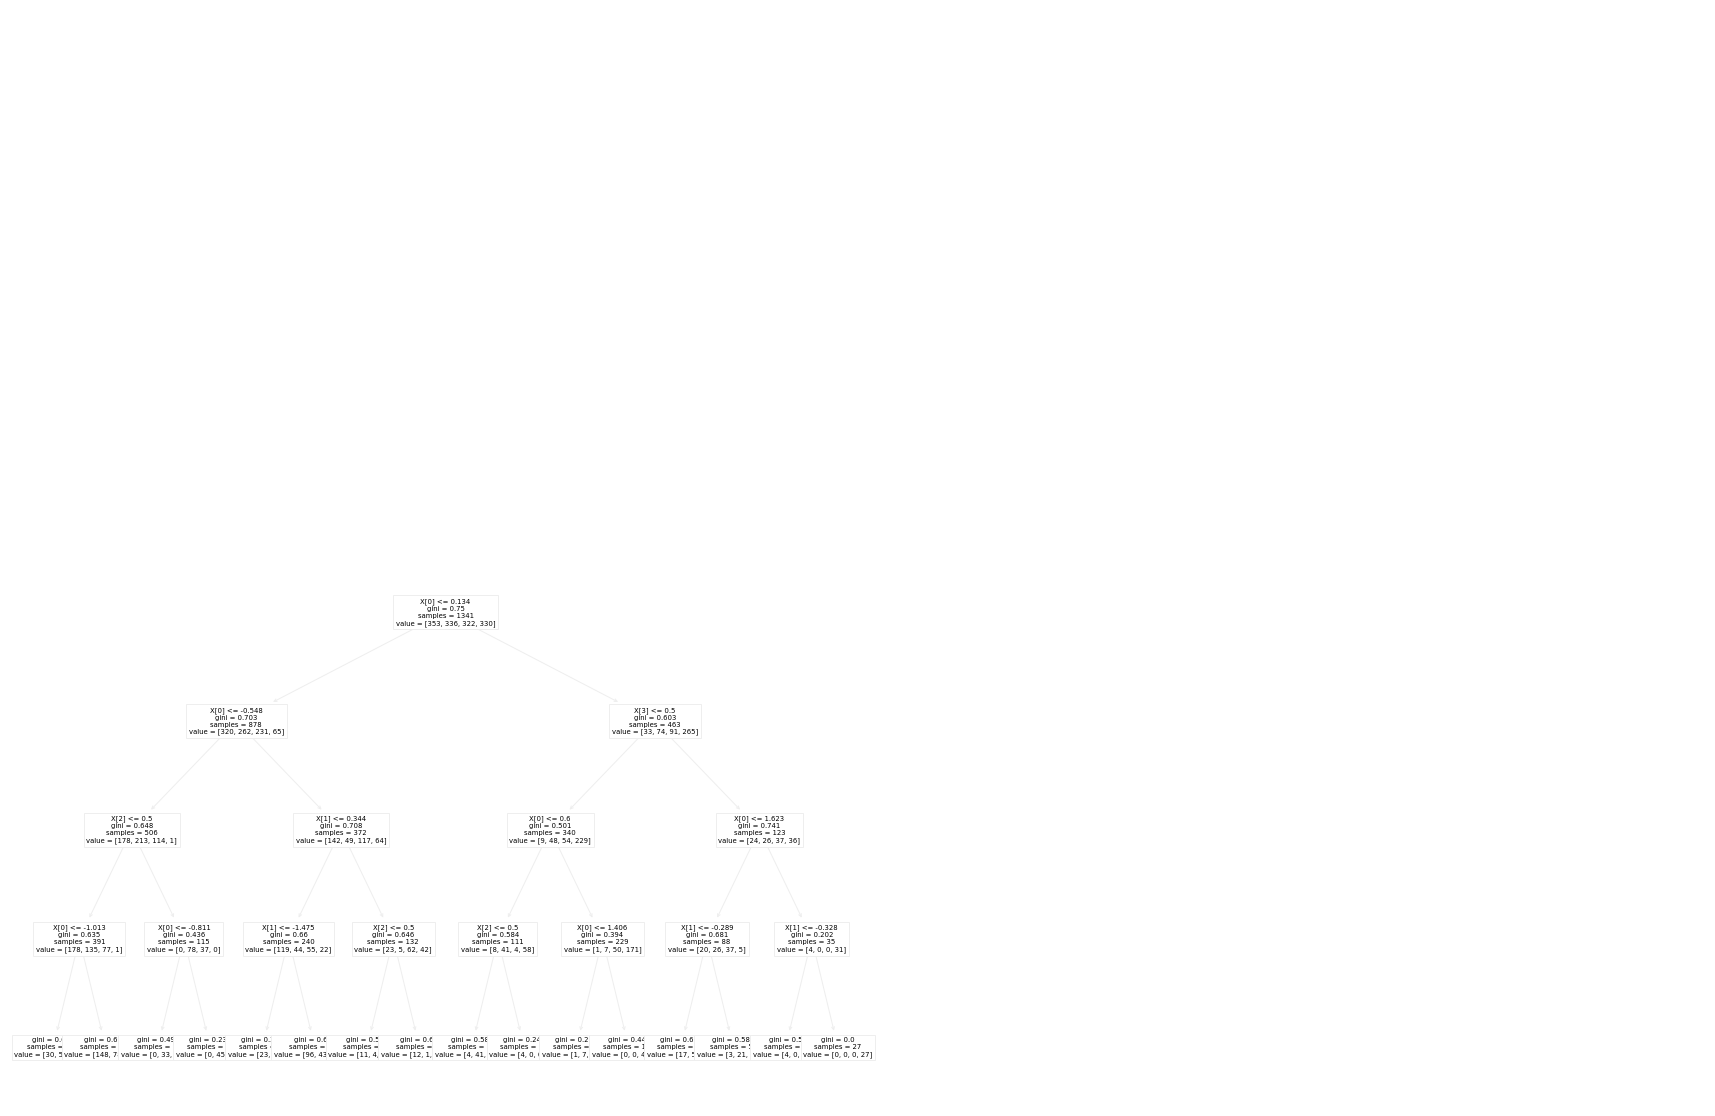

In [68]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#tree_clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
tree_clf = DecisionTreeClassifier(max_depth=4)


tree_clf.fit(X_train_prepped, y_train)
#tree.plot_tree(tree_clf) 


In [71]:
from sklearn import metrics
X_test_prepped = ct_v4.fit_transform(X_test)
y_pred = tree_clf.predict(X_test_prepped)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5952380952380952


## GridSearchCV, DT

In [78]:
tree_clf = DecisionTreeClassifier(random_state=999)

dt_pipe = Pipeline(steps=[('prep',ct_v4), ('tree_clf', tree_clf)])
dt_depth = list(np.arange(1, 20))

dt_params = {'tree_clf__criterion': ['gini', 'entropy'],
             'tree_clf__max_depth': dt_depth,
             'tree_clf__min_samples_split': [2, 3]}

gscv_dt = GridSearchCV(estimator=dt_pipe, 
                     param_grid=dt_params, 
                     #cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

gscv_dt.fit(X_train, y_train);

Fitting 5 folds for each of 76 candidates, totalling 380 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    6.9s finished


In [79]:
gscv_dt.best_params_

{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 8,
 'tree_clf__min_samples_split': 3}

In [80]:
gscv_dt.best_score_

0.6376296953892249

In [81]:
results_DT = pd.DataFrame(gscv_dt.cv_results_['params'])
results_DT['test_score'] = gscv_dt.cv_results_['mean_test_score']
results_DT.columns

Index(['tree_clf__criterion', 'tree_clf__max_depth',
       'tree_clf__min_samples_split', 'test_score'],
      dtype='object')

Text(0.5, 0, 'Max Depth')

Text(0, 0.5, 'Mean CV Score')

Text(0.5, 1.0, 'DT Performance Comparison')

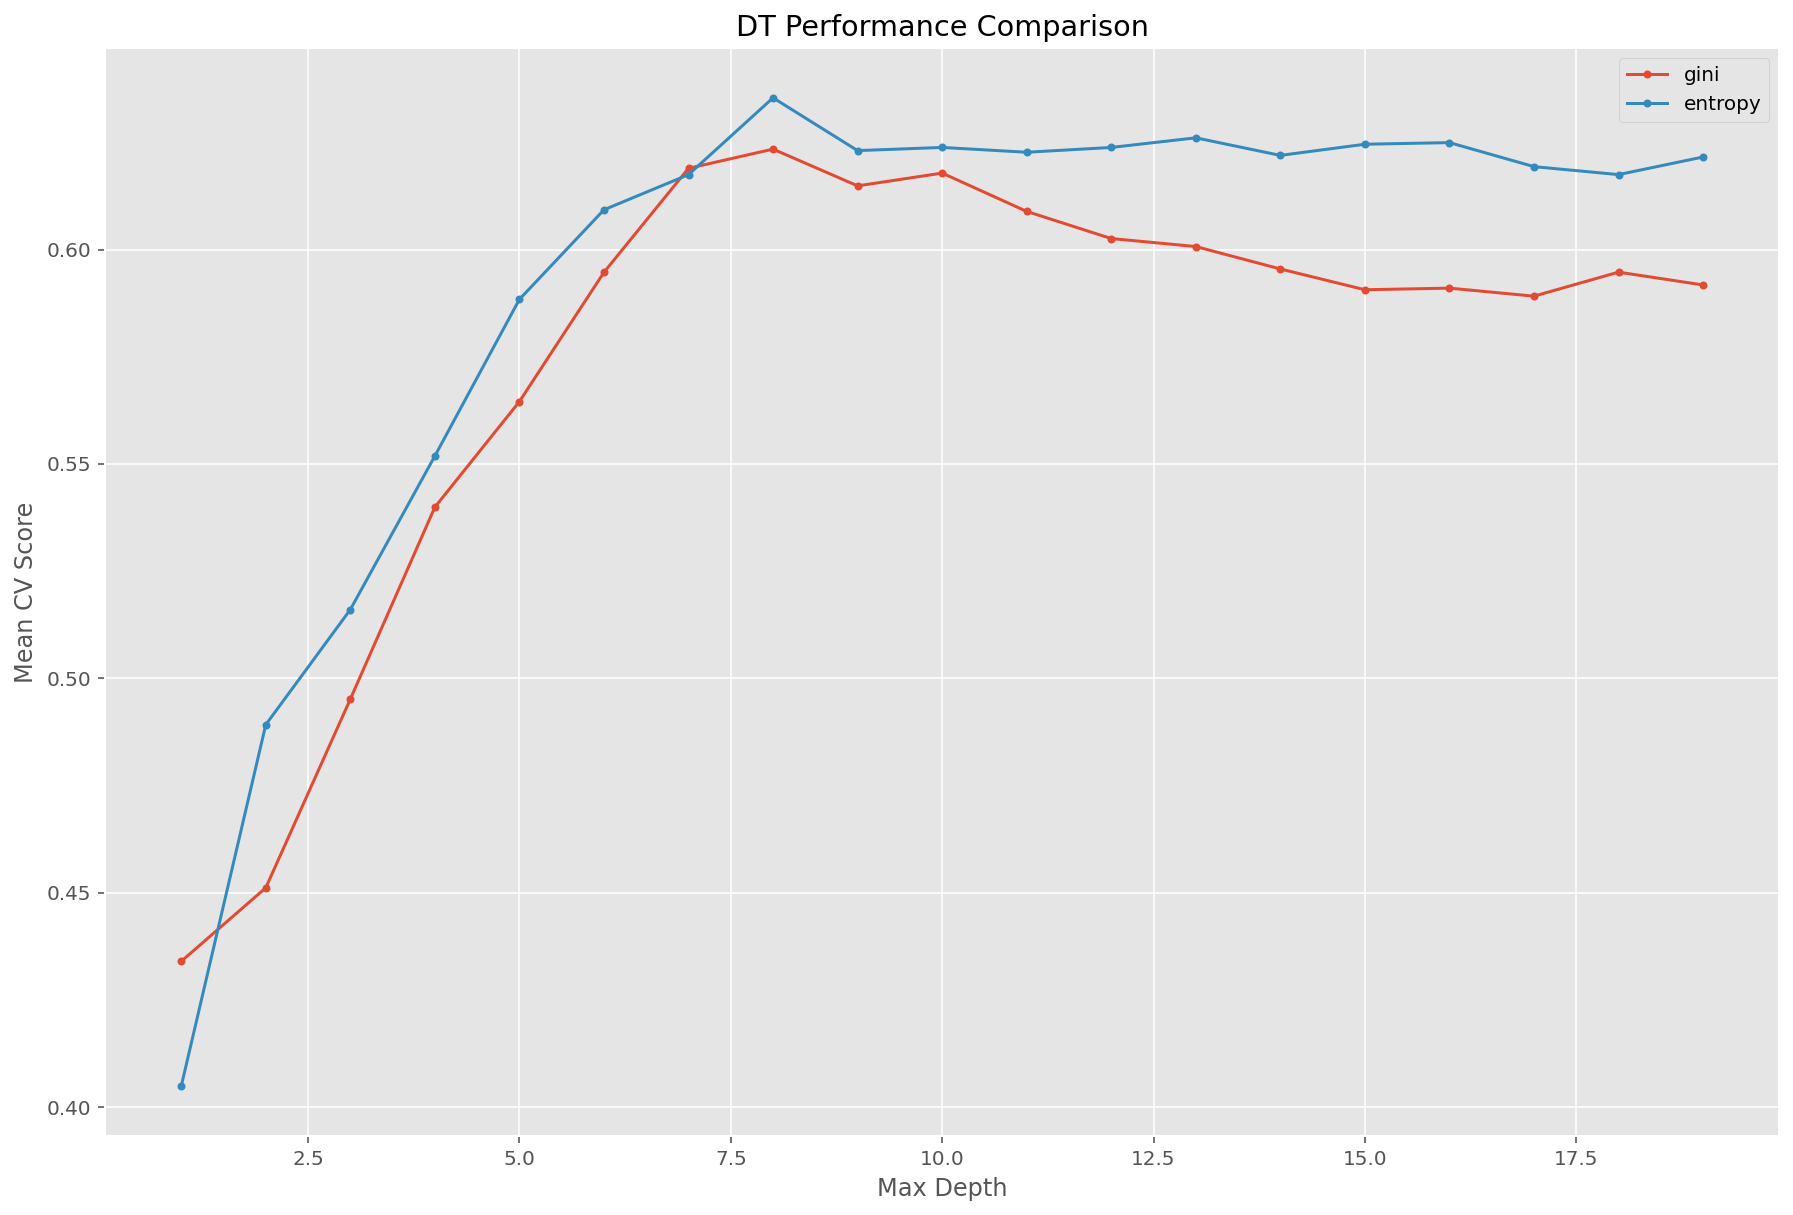

In [82]:
for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['tree_clf__criterion'] == i]
    temp_average = temp.groupby('tree_clf__max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

## GridSearchCV, DT, manual loop

In [84]:
# note: 'col_trans' is list of ColumnTransformers from earlier.
col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
#col_trans = [ct_v4]

dt_depth = list(np.arange(1, 20))

dt_params_grid = {'tree_clf__criterion': ['gini', 'entropy'],
             'tree_clf__max_depth': dt_depth,
             'tree_clf__min_samples_split': [2, 3]}

overall_best_score = 0
overall_best_classifier = None

for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  dt_pipe = Pipeline(steps=[('prep',ct), ('tree_clf', DecisionTreeClassifier(random_state=999))])
  gscv_dt = GridSearchCV(estimator=dt_pipe, 
                     param_grid=dt_params_grid, 
                     #cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

  print('\n>>>>FITTING ....\n')
  _ = gscv_dt.fit(X_train, y_train);

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(gscv_dt.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(gscv_dt.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(gscv_dt.best_params_)

  if gscv_dt.best_score_ > overall_best_score:
    overall_best_score = gscv_dt.best_score_
    overall_best_classifier = gscv_dt


_______________________________________________________

>>>> PIPE #0.. 


>>>>FITTING ....

Fitting 5 folds for each of 76 candidates, totalling 380 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



___BEST ESTIMATOR, pipe#0



[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    6.0s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=11, random_state=999))])


___BEST SCORE, pipe#0



0.6182017422182767


___BEST PARAMS, pipe#0



{'tree_clf__criterion': 'gini',
 'tree_clf__max_depth': 11,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #1.. 


>>>>FITTING ....

Fitting 5 folds for each of 76 candidates, totalling 380 fits

___BEST ESTIMATOR, pipe#1



[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    8.6s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=8,
                                        min_samples_split=3,
                                        random_state=999))])


___BEST SCORE, pipe#1



0.636886200965433


___BEST PARAMS, pipe#1



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 8,
 'tree_clf__min_samples_split': 3}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #2.. 


>>>>FITTING ....

Fitting 5 folds for each of 76 candidates, totalling 380 fits

___BEST ESTIMATOR, pipe#2



[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    7.9s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=11, random_state=999))])


___BEST SCORE, pipe#2



0.6181989679853521


___BEST PARAMS, pipe#2



{'tree_clf__criterion': 'gini',
 'tree_clf__max_depth': 11,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #3.. 


>>>>FITTING ....

Fitting 5 folds for each of 76 candidates, totalling 380 fits

___BEST ESTIMATOR, pipe#3



[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    5.9s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=11, random_state=999))])


___BEST SCORE, pipe#3



0.6196915052987849


___BEST PARAMS, pipe#3



{'tree_clf__criterion': 'gini',
 'tree_clf__max_depth': 11,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #4.. 


>>>>FITTING ....

Fitting 5 folds for each of 76 candidates, totalling 380 fits

___BEST ESTIMATOR, pipe#4



[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    6.8s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_std',
                                                  StandardScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=8,
                                        min_samples_split=3,
                                        random_state=999))])


___BEST SCORE, pipe#4



0.6376296953892249


___BEST PARAMS, pipe#4



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 8,
 'tree_clf__min_samples_split': 3}

Overall ...

In [91]:
print('\n Overall .. BEST SCORE')
display(overall_best_classifier.best_score_)

print('\n Overall .. BEST PARAMS')
display(overall_best_classifier.best_params_)


 Overall .. BEST SCORE


0.6376296953892249


 Overall .. BEST PARAMS


{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 8,
 'tree_clf__min_samples_split': 3}

## Chart results

In [87]:
dt_results = pd.DataFrame(overall_best_classifier.cv_results_['params'])
dt_results['test_score'] = overall_best_classifier.cv_results_['mean_test_score']
dt_results.columns

Index(['tree_clf__criterion', 'tree_clf__max_depth',
       'tree_clf__min_samples_split', 'test_score'],
      dtype='object')

Text(0.5, 0, 'Max Depth')

Text(0, 0.5, 'Mean CV Score')

Text(0.5, 1.0, 'DT Performance Comparison')

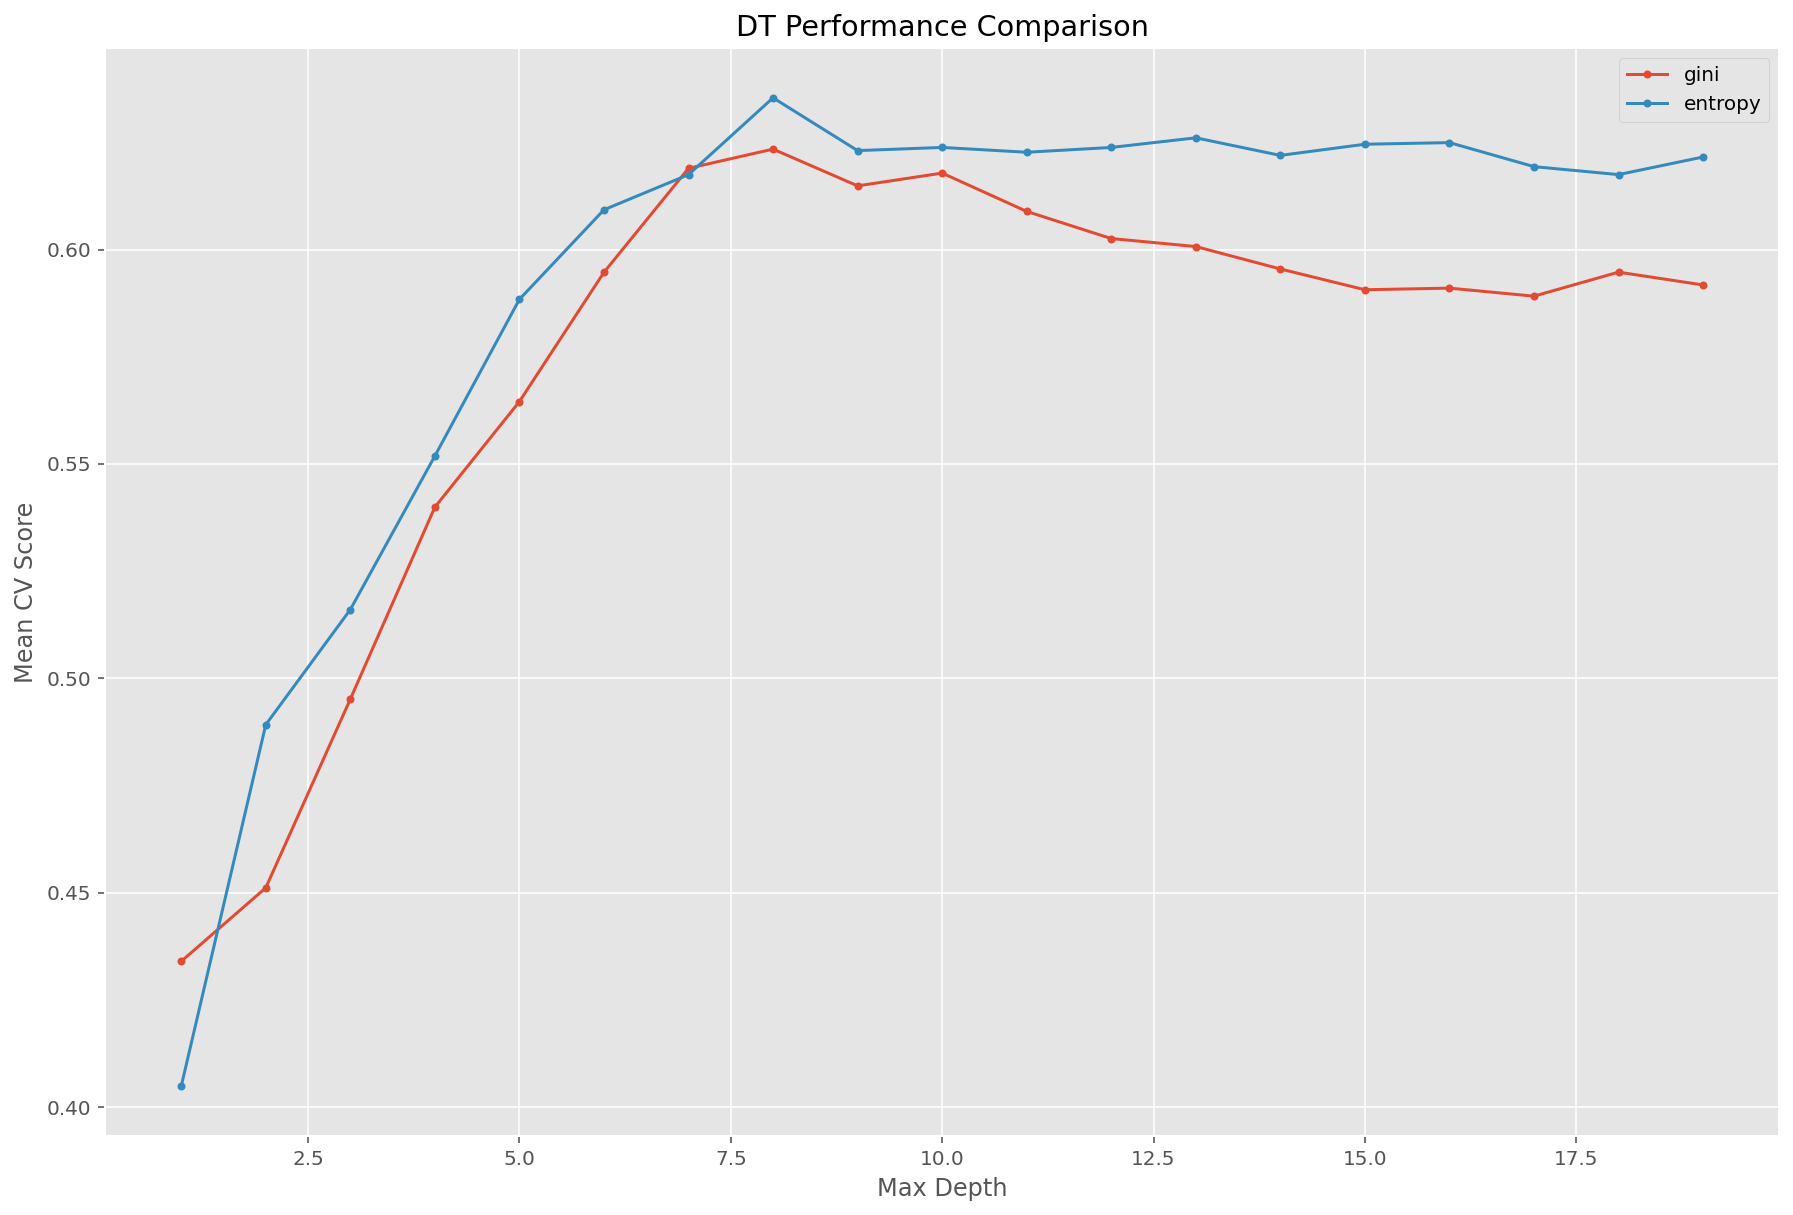

In [88]:

for i in ['gini', 'entropy']:
    tmp_crit = dt_results[dt_results['tree_clf__criterion'] == i]
    tmp_avg = tmp_crit.groupby('tree_clf__max_depth').agg({'test_score': 'mean'})
    plt.plot(tmp_avg, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

## Run on test data

In [89]:
y_pred = overall_best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    drummer1       0.60      0.77      0.67        94
    drummer5       0.66      0.63      0.64        83
    drummer7       0.66      0.35      0.46        89
    drummer8       0.64      0.83      0.73        70

    accuracy                           0.63       336
   macro avg       0.64      0.64      0.62       336
weighted avg       0.64      0.63      0.62       336

